In [95]:
import bs4 as bs
import pickle 
import datetime as dt
import os
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader._utils import RemoteDataError
import requests
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
%matplotlib notebook

In [75]:
style.use('ggplot')

In [76]:
def save_sp500_companies():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open('sp500tickers.pickle', 'wb') as f:
        pickle.dump(tickers, f)
        
    return tickers

In [84]:
def get_yahoo_data(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_companies()
    else:
        with open('sp500tickers.pickle', 'rb') as f:
            tickers = pickle.load(f)
    
    if not os.path.exists('stocks'):
        os.makedirs('stocks')
        
    start = dt.datetime(2000, 1, 1)
    end = dt.datetime(2016, 12, 31)
    
    for ticker in tickers:
        print(ticker)
        if not os.path.exists('stocks/{}.csv'.format(ticker)):
            try:
                df = web.DataReader(ticker, 'yahoo', start, end)
                df.to_csv('stocks/{}.csv'.format(ticker))       
            except RemoteDataError:
                print('Unable to get {}'.format(ticker))
                continue

In [78]:
def compile_data():
    with open('sp500tickers.pickle', 'rb') as f:
        tickers = pickle.load(f)
        
    main_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers):
        try:
            df = pd.read_csv('stocks/{}.csv'.format(ticker))
            df.set_index('Date', inplace=True)

            df.rename(columns={'Adj Close': ticker}, inplace=True)
            df.drop(['Open','High','Low','Close','Volume'], 1, inplace=True)
            
            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.join(df, how='outer')
                
        except FileNotFoundError:
            continue
    
    main_df.to_csv('sp500_joined_closes.csv')

In [96]:
def visualise_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    df_corr = df.corr()

    df_corr.to_csv('sp500_correlations.csv')
    data = df_corr.values
    fig = plt.figure()
    
    ax = fig.add_subplot(1,1,1)
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)    
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    
    ax.invert_yaxis()    
    ax.xaxis.tick_top()

    column_labels = df_corr.columns
    row_labels = df_corr.indexj
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    
    plt.xticks(rotation=90)
    heatmap.set_clim(-1, 1)

    
    

#     df['AMD'].plot()
#     plt.show()
    

<IPython.core.display.Javascript object>


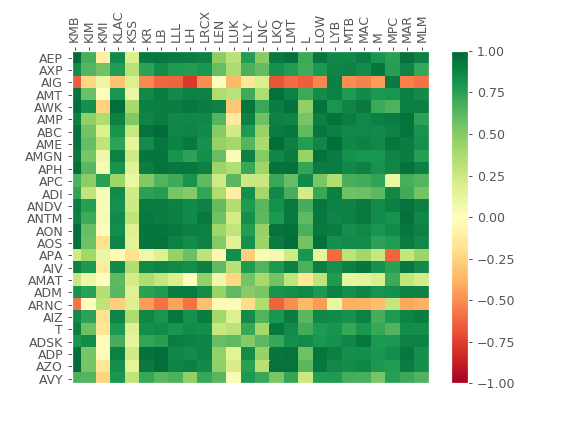

In [97]:
visualise_data()